In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

df = pd.read_csv("air_quality_global.csv")

print(df.shape)
print(df.head())


(6480, 11)
       city country  latitude  longitude  year  month  pm25_ugm3  no2_ugm3  \
0  New York     USA   40.7128    -74.006  1999      1      18.11     35.98   
1  New York     USA   40.7128    -74.006  1999      2      27.79     17.71   
2  New York     USA   40.7128    -74.006  1999      3      12.05     40.99   
3  New York     USA   40.7128    -74.006  1999      4      35.25     17.18   
4  New York     USA   40.7128    -74.006  1999      5      38.39     25.07   

  data_quality           measurement_method data_source  
0     Moderate  Reference/Equivalent Method     EPA_AQS  
1         Good  Reference/Equivalent Method     EPA_AQS  
2     Moderate  Reference/Equivalent Method     EPA_AQS  
3         Poor  Reference/Equivalent Method     EPA_AQS  
4         Good  Reference/Equivalent Method     EPA_AQS  


In [3]:
print(df.isnull().sum())

df.drop_duplicates(inplace=True)

df['pm25_ugm3'] = df['pm25_ugm3'].fillna(df['pm25_ugm3'].median())
df['no2_ugm3'] = df['no2_ugm3'].fillna(df['no2_ugm3'].median())

df['data_quality'] = df['data_quality'].fillna('Unknown')
df['measurement_method'] = df['measurement_method'].fillna('Unknown')

df['date'] = pd.to_datetime(df[['year', 'month']].assign(day=1))


city                  0
country               0
latitude              0
longitude             0
year                  0
month                 0
pm25_ugm3             0
no2_ugm3              0
data_quality          0
measurement_method    0
data_source           0
dtype: int64


In [6]:
print(df.describe())
print(df['country'].value_counts().head(10))



          latitude    longitude         year        month    pm25_ugm3  \
count  6480.000000  6480.000000  6480.000000  6480.000000  6480.000000   
mean     31.535510   -35.877325  2012.000000     6.500000    40.968210   
min     -23.550500  -121.886300  1999.000000     1.000000     5.100000   
25%      29.244100   -98.653500  2005.000000     3.750000    19.337500   
50%      33.750300   -74.585600  2012.000000     6.500000    29.225000   
75%      40.142650     5.885650  2019.000000     9.250000    46.080000   
max      52.520000   139.650300  2025.000000    12.000000   274.180000   
std      16.603137    81.511132     7.789482     3.452319    36.303963   

          no2_ugm3                           date  
count  6480.000000                           6480  
mean     39.617276  2012-06-16 02:04:26.666666752  
min      10.250000            1999-01-01 00:00:00  
25%      27.080000            2005-09-23 12:00:00  
50%      36.845000            2012-06-16 00:00:00  
75%      48.922500   

In [10]:
avg_country = df.groupby('country')[['pm25_ugm3', 'no2_ugm3']].mean().sort_values('pm25_ugm3', ascending=False)
print(avg_country.head(10))


          pm25_ugm3   no2_ugm3
country                       
India    115.638534  57.082855
China     75.325123  59.496481
Nigeria   66.638086  43.576821
Mexico    53.446698  55.246698
Brazil    40.879691  47.702068
Japan     29.550494  35.454907
UK        29.103148  44.058858
France    27.201821  40.269846
Germany   24.725062  35.440895
USA       24.121701  31.693324


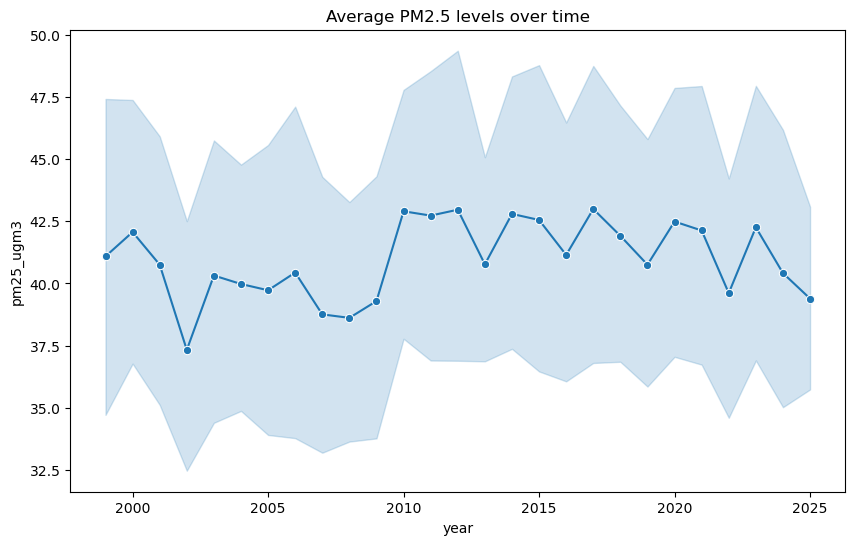

In [11]:
monthly_trend = df.groupby(['year', 'month'])[['pm25_ugm3', 'no2_ugm3']].mean().reset_index()
plt.figure(figsize=(10,6))
sns.lineplot(data=monthly_trend, x='year', y='pm25_ugm3', marker='o')
plt.title('Average PM2.5 levels over time')
plt.show()


# Visualization Insights

# Top polluted cities

C:\Users\asus\AppData\Local\Temp\ipykernel_11772\1086807673.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_cities.values, y=top_cities.index, palette='Reds_r')


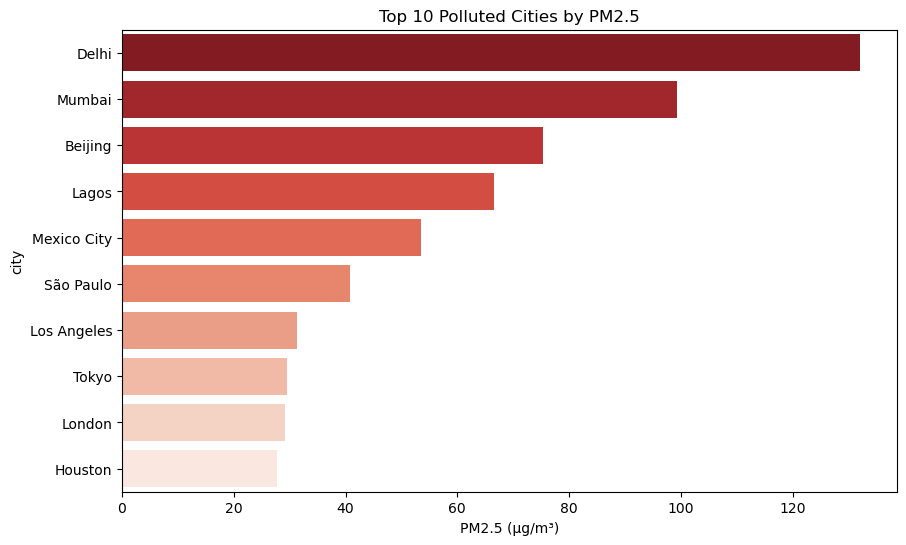

In [16]:
top_cities = df.groupby('city')['pm25_ugm3'].mean().sort_values(ascending=False).head(10)
plt.figure(figsize=(10,6))
sns.barplot(x=top_cities.values, y=top_cities.index, palette='Reds_r')
plt.title('Top 10 Polluted Cities by PM2.5')
plt.xlabel('PM2.5 (µg/m³)')
plt.show()


# PM2.5 vs NO₂ relationship

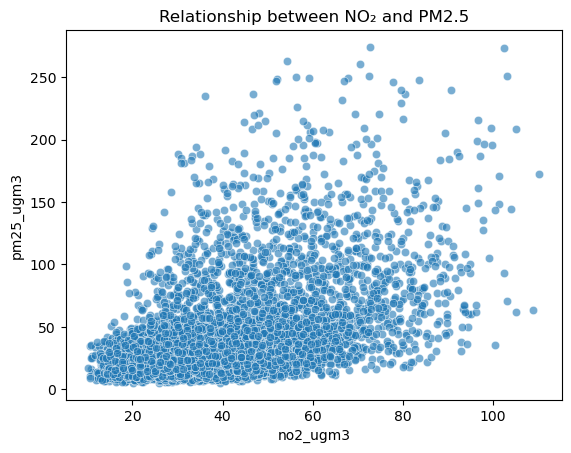

In [17]:
sns.scatterplot(data=df, x='no2_ugm3', y='pm25_ugm3', alpha=0.6)
plt.title('Relationship between NO₂ and PM2.5')
plt.show()


# World map visualization

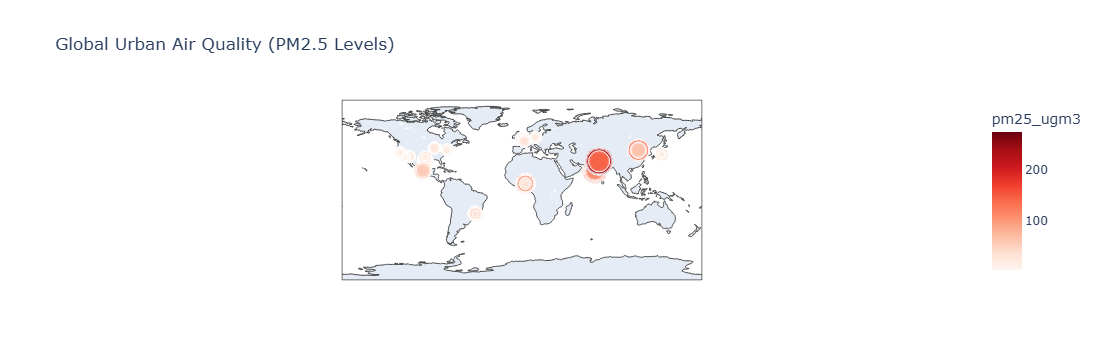

In [26]:
fig = px.scatter_geo(df,
                     lat='latitude', lon='longitude',
                     color='pm25_ugm3',
                     hover_name='city',
                     size='pm25_ugm3',
                     title='Global Urban Air Quality (PM2.5 Levels)',
                     color_continuous_scale='Reds')
fig.show()


# Compare measurement methods

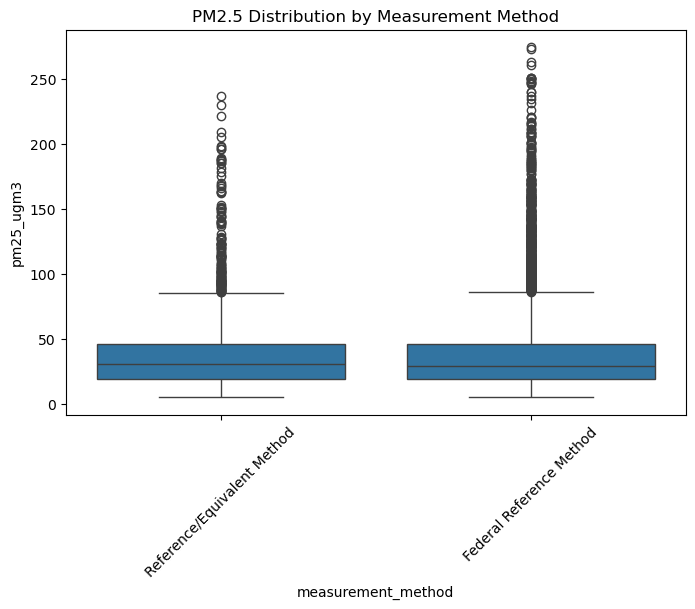

In [29]:
plt.figure(figsize=(8,5))
sns.boxplot(data=df, x='measurement_method', y='pm25_ugm3')
plt.xticks(rotation=45)
plt.title('PM2.5 Distribution by Measurement Method')
plt.show()


# Data Preprocessing for Modeling

We’ll predict PM2.5 using other numerical features

In [42]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

categorical_cols = ['data_quality', 'measurement_method', 'data_source', 'country']
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])


X = df[['no2_ugm3', 'latitude', 'longitude', 'year', 'month', 'data_quality', 'measurement_method']]
y = df['pm25_ugm3']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


# Predictive Modeling

Let’s start with Linear Regression, then evaluate.

In [52]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"R²: {r2:.2f}")


MAE: 17.22
MSE: 704.07
R²: 0.43


# VISUALIZATION

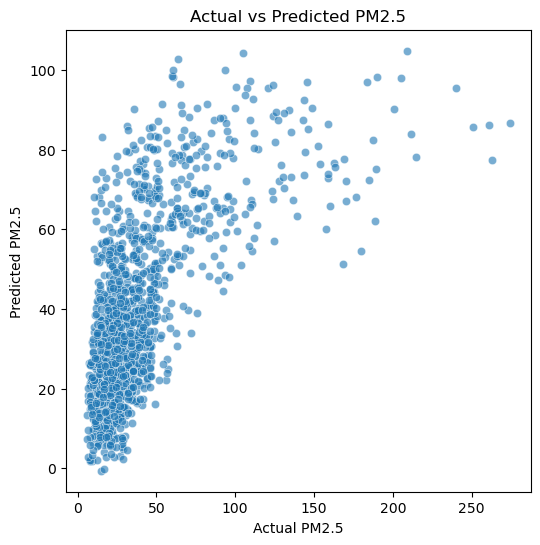

In [54]:
plt.figure(figsize=(6,6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)
plt.xlabel("Actual PM2.5")
plt.ylabel("Predicted PM2.5")
plt.title("Actual vs Predicted PM2.5")
plt.show()


In [56]:
import streamlit as st
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

st.set_page_config(page_title="Urban Air Quality Analytics", layout="wide")
st.title("🌆 Urban Air Quality Data Analysis and Prediction")


2025-10-21 13:24:33.596 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-21 13:24:33.599 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-21 13:24:33.601 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


DeltaGenerator()

In [60]:
st.header("📂st")

uploaded_file = st.file_uploader("air_quality_global.csv", type=["csv"])

if uploaded_file:
    df = pd.read_csv(uploaded_file)
    st.success("✅ Data successfully loaded!")
else:
    st.info("Please upload your dataset (e.g., `global_air_quality.csv`).")
    st.stop()

st.subheader("Preview of the dataset")
st.dataframe(df.head())


2025-10-22 19:35:44.583 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-22 19:35:44.584 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-22 19:35:44.587 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-22 19:35:44.588 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-22 19:35:44.590 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-22 19:35:44.592 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-22 19:35:44.593 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-22 19:35:44.597 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

DeltaGenerator()